<pre><b>Author</b>: Ashlynn Wimer
<b>Date</b>: 2/19/2024</pre>

## Migration Analysis Notebook

This notebook is the "cleaned up" presentation of the analysis of hospital closures on outmigration. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

### Preprocessing

Below is the data preprocessing for our analysis. We create most of the variables that we need for future steps below, so expect to see a few variables get created and then go unused for a while; we'll try to flag those variables when that occurs.

In [2]:
# Read in data

hosps = pd.read_csv('../data/HospitalAttributes.csv', dtype={'ClosureYear':str, 'GEOID':str})[['GEOID', 'ClosureYear', 'Converted', 'HasClosed']]
hosps.loc[hosps["ClosureYear"].isna(), 'ClosureYear'] = -9999

closures = hosps.copy()[hosps['ClosureYear'] != -9999]
closures['GEOID'] = closures['GEOID'].apply(lambda x: str(x).rjust(5, '0'))

irs_data = pd.read_csv('../data/irs_data.csv', dtype={'GEOID':str, 'Year':str})
irs_data = irs_data[(irs_data['Outflow_Individual'] != -1) & (irs_data['Inflow_Individual'] != -1)]

census = pd.read_csv('../data/census_data_acs5.csv', dtype={'GEOID':str, 'Year':str})[['GEOID', 'Year', 'Total Population']]

We start by creating the data for a quick visual analysis.

In [3]:
df = irs_data\
    .merge(
    census, how='right', on=['GEOID', 'Year']
    ).merge(
        closures, how='right', left_on='GEOID', right_on='GEOID'
    ).drop_duplicates()

df['OutflowPerCap'] = df['Outflow_Individual'] / df['Total Population']
df['InflowPerCap'] = df['Inflow_Individual'] / df['Total Population']
df['OutflowAGIPerCap'] = df['Outflow_AGI'] / df['Outflow_Individual']
df['InflowAGIPerCap'] = df['Inflow_AGI'] / df['Inflow_Individual']

df = df[['GEOID', 'Year', 'ClosureYear', 
         'Converted', 'OutflowPerCap', 
         'InflowPerCap', 'OutflowAGIPerCap', 
         'InflowAGIPerCap']]
df['Year'] = df['Year'].astype(int)
df['ClosureYear'] = df['ClosureYear'].apply(lambda x: int(float(x)))

df['Years_Since_Close'] = df[['Year', 'ClosureYear']].apply(
  lambda x: x['Year'] - x['ClosureYear'], axis=1
)

df.head()

,GEOID,Year,ClosureYear,Converted,OutflowPerCap,InflowPerCap,OutflowAGIPerCap,InflowAGIPerCap,Years_Since_Close
0,01031,2011,2013,1.0,0.093090,0.093639,19.271715,18.376654,-2
1,01031,2012,2013,1.0,0.093584,0.086819,19.434987,17.787690,-1
2,01031,2013,2013,1.0,0.079139,0.080764,19.687031,17.952159,0
3,01031,2014,2013,1.0,0.055534,0.059240,19.922968,18.948419,1
4,01031,2015,2013,1.0,0.077215,0.082285,23.744464,19.296155,2


And then we create the data for the DID analysis. Note that we're comparing converted hospitals to "not converted" (meaning closed hospitals are in the category) and closed hospitals to "not closed" (meaning that converted hospitals are in the category). Given the much larger size of non-closed hospitals to closed hospitals, this shouldn't be an issue. 

In [4]:
diddf = irs_data.copy().merge(
    census, how='outer', on=['GEOID', 'Year']
    ).merge( # left as we're interested in the *counties*
        hosps, how='left', left_on='GEOID', right_on='GEOID'
    ).drop_duplicates()

diddf['OutflowPerCap'] = diddf['Outflow_Individual'] / diddf['Total Population']
diddf['InflowPerCap'] = diddf['Inflow_Individual'] / diddf['Total Population']
diddf['OutflowAGIPerCap'] = diddf['Outflow_AGI'] / diddf['Outflow_Individual']
diddf['InflowAGIPerCap'] = diddf['Inflow_AGI'] / diddf['Inflow_Individual']

diddf = diddf.drop(['Outflow_Individual', 'Outflow_Household', 'Outflow_AGI', 
                    'Inflow_AGI', 'Inflow_Individual', 'Inflow_Household', 'Total Population'], axis=1)

diddf.loc[diddf['ClosureYear'].isna() | diddf['Converted'].isna(), ['ClosureYear', 'Converted']] = -9999

diddf = diddf.dropna()

diddf[(diddf['ClosureYear'] != -9999) & (diddf['Converted'] == 0)]

,Year,GEOID,ClosureYear,Converted,HasClosed,OutflowPerCap,InflowPerCap,OutflowAGIPerCap,InflowAGIPerCap
2148,2011,01021,2012.0,0.0,1.0,0.049558,0.051446,11.657222,12.901119
2157,2012,01021,2012.0,0.0,1.0,0.049552,0.053175,15.291994,13.973696
2166,2013,01021,2012.0,0.0,1.0,0.042794,0.047001,14.081731,13.444553
2175,2014,01021,2012.0,0.0,1.0,0.033576,0.032457,15.310204,17.041520
2184,2015,01021,2012.0,0.0,1.0,0.037655,0.039093,15.540000,18.706947
...,...,...,...,...,...,...,...,...,...
847468,2016,51141,2017.0,0.0,1.0,0.036194,0.043949,16.962006,22.327910
847475,2017,51141,2017.0,0.0,1.0,0.030237,0.033801,20.342541,18.436573
847482,2018,51141,2017.0,0.0,1.0,0.030517,0.032533,20.959633,22.597246
847489,2019,51141,2017.0,0.0,1.0,0.030370,0.033694,20.545455,23.757525


Now, we need to do two more slightly complicated steps.

1. Create a variable called "prior_full_closure" for each county which marks whether there was ever a prior _full_ closure. We also must do similarly for partial closures. 

2. Create dummy variables for each of our `GEOIDs.` 



In [5]:
diddf = diddf.sort_values(by=['GEOID', 'Year'])
prior_full_closure = []
prior_partial_closure = []
current_geoid = None
    
# Create the prior_TYPE_closure variables
for index, row in diddf.iterrows():
    # Hasn't closed
    if row['ClosureYear'] == -9999:
        prior_full_closure.append(0)
        prior_partial_closure.append(0)
        continue

    # Has a closure, but not yet
    if int(float(row['ClosureYear'])) > int(row['Year']):
        prior_full_closure.append(0)
        prior_partial_closure.append(0)
        continue    

    # Full closure
    if row['Converted'] == 0:
        prior_full_closure.append(1)
        prior_partial_closure.append(0)

    # Partial closure
    if row['Converted'] == 1:
        prior_full_closure.append(0)
        prior_partial_closure.append(1)

diddf['prior_full_closure'] = prior_full_closure
diddf['prior_partial_closure'] = prior_partial_closure

In [6]:
diddf = pd.get_dummies(diddf, columns=['GEOID'], prefix='COUNTY', dtype=int)
diddf = pd.get_dummies(diddf, columns=['Year'], prefix='Year', dtype=int)

diddf = diddf.drop(['ClosureYear', 'Converted', 'HasClosed'], axis=1)
diddf.head()

,OutflowPerCap,InflowPerCap,OutflowAGIPerCap,InflowAGIPerCap,prior_full_closure,prior_partial_closure,COUNTY_01001,COUNTY_01003,COUNTY_01005,COUNTY_01007,...,Year_2011,Year_2012,Year_2013,Year_2014,Year_2015,Year_2016,Year_2017,Year_2018,Year_2019,Year_2020
0,0.088536,0.085607,18.973199,18.080121,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
13,0.077597,0.084759,19.957979,18.744543,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
26,0.079261,0.079079,19.543199,18.727775,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
39,0.047247,0.053341,20.170058,18.883033,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
52,0.071132,0.078340,22.593686,21.786870,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [7]:
diddf.shape

(24988, 2439)

In [8]:
diddf

,OutflowPerCap,InflowPerCap,OutflowAGIPerCap,InflowAGIPerCap,prior_full_closure,prior_partial_closure,COUNTY_01001,COUNTY_01003,COUNTY_01005,COUNTY_01007,...,Year_2011,Year_2012,Year_2013,Year_2014,Year_2015,Year_2016,Year_2017,Year_2018,Year_2019,Year_2020
0,0.088536,0.085607,18.973199,18.080121,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
13,0.077597,0.084759,19.957979,18.744543,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
26,0.079261,0.079079,19.543199,18.727775,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
39,0.047247,0.053341,20.170058,18.883033,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
52,0.071132,0.078340,22.593686,21.786870,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
908557,0.073171,0.041812,23.121905,26.290000,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
908570,0.046087,0.043979,24.725610,25.824281,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
908583,0.044507,0.048592,29.237342,30.869565,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
908596,0.048659,0.046248,37.927114,31.726994,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### Visual Analysis

This is an EDA to get a sense of what we should expect from the DID analysis. 

For this analysis, we'll plot the mean and median values of our per capita variables when grouped by conversion status and years since close.

In [9]:
# Construct mean, median dataframes
df_mean = df.drop('GEOID', axis=1).groupby(['Years_Since_Close', 'Converted']).mean().reset_index().dropna()
df_median = df.drop('GEOID', axis=1).groupby(['Years_Since_Close', 'Converted']).median().reset_index().dropna()

df_mean.head()

,Years_Since_Close,Converted,Year,ClosureYear,OutflowPerCap,InflowPerCap,OutflowAGIPerCap,InflowAGIPerCap
0,-12,0.0,2011.000000,2023.000000,0.049220,0.048939,17.840639,16.414621
1,-12,1.0,2011.000000,2023.000000,0.040352,0.039946,17.784927,16.031387
2,-11,0.0,2011.636364,2022.636364,0.046401,0.045642,17.897510,17.850238
3,-11,1.0,2011.666667,2022.666667,0.039953,0.037912,19.334589,19.094676
4,-10,0.0,2012.636364,2022.636364,0.043753,0.043553,19.136333,19.237458


#### Mean vs Median Outflow Per Capita

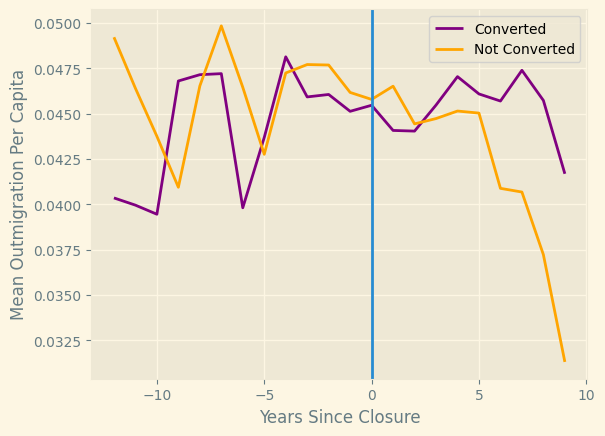

In [10]:
plt.style.use('Solarize_Light2')
fig, ax = plt.subplots()

group_1, group_2 = df_mean[df_mean["Converted"] == 1], df_mean[df_mean["Converted"] == 0]
ax.plot(group_1['Years_Since_Close'], group_1['OutflowPerCap'], color='Purple', label='Converted')
ax.plot(group_2['Years_Since_Close'], group_2['OutflowPerCap'], color='Orange', label='Not Converted')

ax.legend()

ax.set_xlabel('Years Since Closure')
ax.set_ylabel('Mean Outmigration Per Capita')

ax.axvline(0)
plt.show()

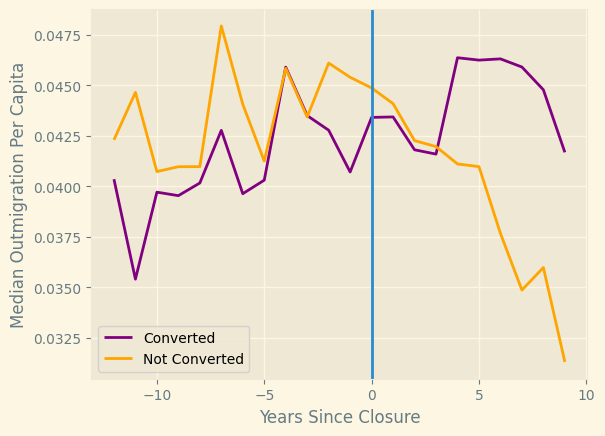

In [11]:
plt.style.use('Solarize_Light2')
fig, ax = plt.subplots()

group_1, group_2 = df_median[df_median["Converted"] == 1], df_median[df_median["Converted"] == 0]
ax.plot(group_1['Years_Since_Close'], group_1['OutflowPerCap'], color='Purple', label='Converted')
ax.plot(group_2['Years_Since_Close'], group_2['OutflowPerCap'], color='Orange', label='Not Converted')

ax.legend()

ax.set_xlabel('Years Since Closure')
ax.set_ylabel('Median Outmigration Per Capita')

ax.axvline(0)
plt.show()

#### Mean vs Median Inflow Per Capita

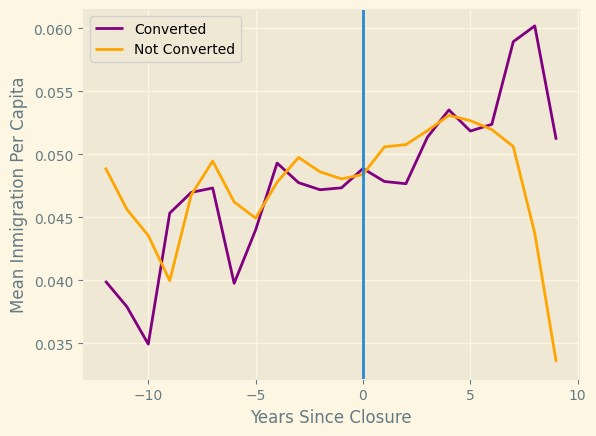

In [12]:
plt.style.use('Solarize_Light2')
fig, ax = plt.subplots()

group_1, group_2 = df_mean[df_mean["Converted"] == 1], df_mean[df_mean["Converted"] == 0]
ax.plot(group_1['Years_Since_Close'], group_1['InflowPerCap'], color='Purple', label='Converted')
ax.plot(group_2['Years_Since_Close'], group_2['InflowPerCap'], color='Orange', label='Not Converted')

ax.legend()

ax.set_xlabel('Years Since Closure')
ax.set_ylabel('Mean Inmigration Per Capita')

ax.axvline(0)
plt.show()

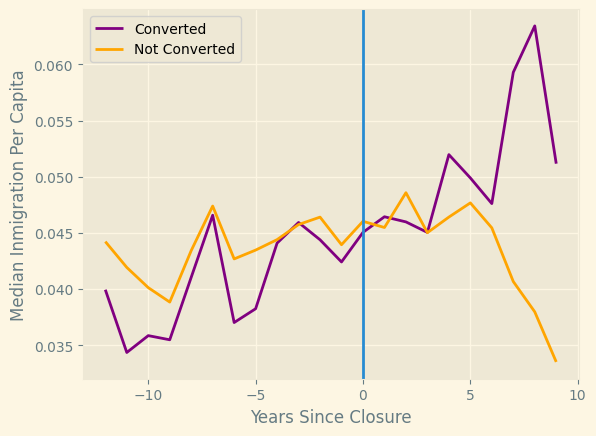

In [13]:
plt.style.use('Solarize_Light2')
fig, ax = plt.subplots()

group_1, group_2 = df_median[df_median["Converted"] == 1], df_median[df_median["Converted"] == 0]
ax.plot(group_1['Years_Since_Close'], group_1['InflowPerCap'], color='Purple', label='Converted')
ax.plot(group_2['Years_Since_Close'], group_2['InflowPerCap'], color='Orange', label='Not Converted')

ax.legend()

ax.set_xlabel('Years Since Closure')
ax.set_ylabel('Median Inmigration Per Capita')

ax.axvline(0)
plt.show()

#### Mean vs Median OutflowAGI Per Capita

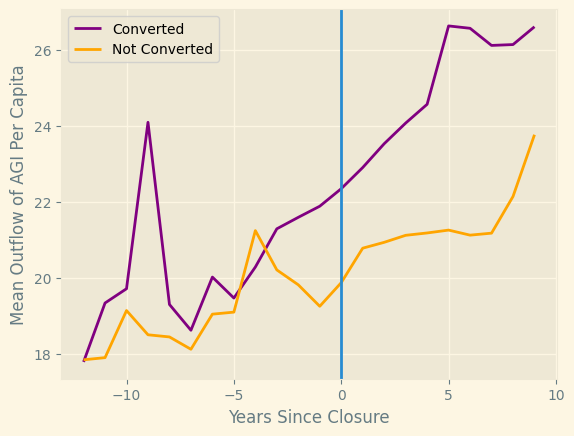

In [14]:
plt.style.use('Solarize_Light2')
fig, ax = plt.subplots()

group_1, group_2 = df_mean[df_mean["Converted"] == 1], df_mean[df_mean["Converted"] == 0]
ax.plot(group_1['Years_Since_Close'], group_1['OutflowAGIPerCap'], color='Purple', label='Converted')
ax.plot(group_2['Years_Since_Close'], group_2['OutflowAGIPerCap'], color='Orange', label='Not Converted')

ax.legend()

ax.set_xlabel('Years Since Closure')
ax.set_ylabel('Mean Outflow of AGI Per Capita')

ax.axvline(0)
plt.show()

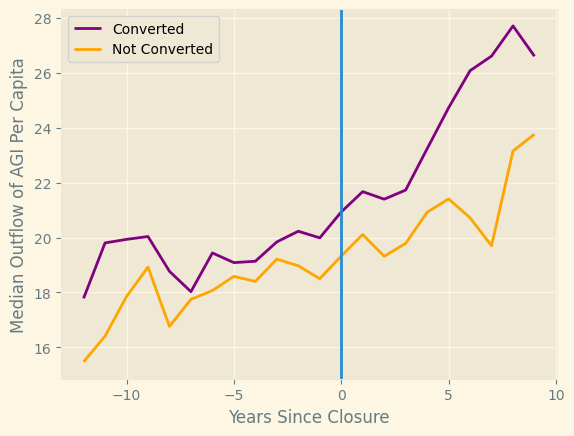

In [15]:
plt.style.use('Solarize_Light2')
fig, ax = plt.subplots()

group_1, group_2 = df_median[df_median["Converted"] == 1], df_median[df_median["Converted"] == 0]
ax.plot(group_1['Years_Since_Close'], group_1['OutflowAGIPerCap'], color='Purple', label='Converted')
ax.plot(group_2['Years_Since_Close'], group_2['OutflowAGIPerCap'], color='Orange', label='Not Converted')

ax.legend()

ax.set_xlabel('Years Since Closure')
ax.set_ylabel('Median Outflow of AGI Per Capita')

ax.axvline(0)
plt.show()

#### Mean vs Median Inflow AGI Per Cap

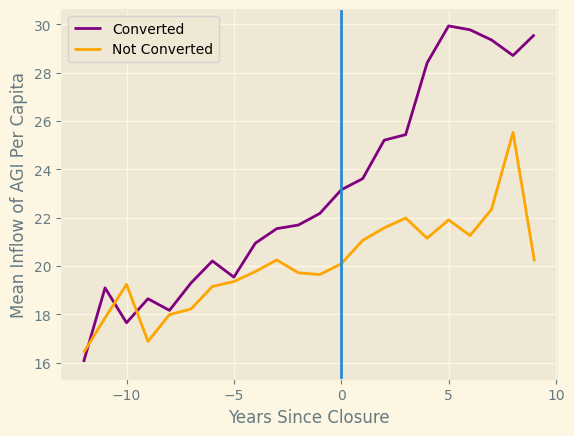

In [16]:
plt.style.use('Solarize_Light2')
fig, ax = plt.subplots()

group_1, group_2 = df_mean[df_mean["Converted"] == 1], df_mean[df_mean["Converted"] == 0]
ax.plot(group_1['Years_Since_Close'], group_1['InflowAGIPerCap'], color='Purple', label='Converted')
ax.plot(group_2['Years_Since_Close'], group_2['InflowAGIPerCap'], color='Orange', label='Not Converted')

ax.legend()

ax.set_xlabel('Years Since Closure')
ax.set_ylabel('Mean Inflow of AGI Per Capita')

ax.axvline(0)
plt.show()

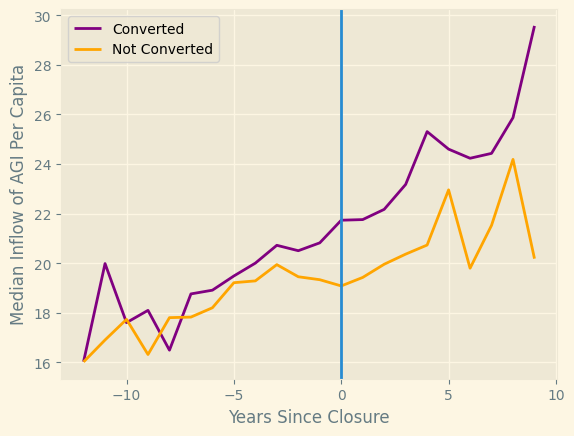

In [17]:
plt.style.use('Solarize_Light2')
fig, ax = plt.subplots()

group_1, group_2 = df_median[df_median["Converted"] == 1], df_median[df_median["Converted"] == 0]
ax.plot(group_1['Years_Since_Close'], group_1['InflowAGIPerCap'], color='Purple', label='Converted')
ax.plot(group_2['Years_Since_Close'], group_2['InflowAGIPerCap'], color='Orange', label='Not Converted')

ax.legend()

ax.set_xlabel('Years Since Closure')
ax.set_ylabel('Median Inflow of AGI Per Capita')

ax.axvline(0)
plt.show()

### DID

We perform a difference and difference analysis to investigate the existence (or lack thereof) of a casual relationship between having a hospital close in a county X and their future migration trends, both in-migration and out-migration. We use the following regression equation:

$$Y_{c,t} = \beta + \delta_{\text{DID}}\text{TREAT}_{c,t} + \sum\limits_{k\in\text{Counties}}\alpha_k \text{COUNTY}_{k,c} + \sum\limits_{n=2011}^{2020} \theta_t \text{YEAR}_{n, t}$$

Where $Y_{c,t}$ is our outcome variable of interest, $\beta$ is our constant, $\delta_{\text{DID}}$ is the coefficient of our DID regression, $\text{TREAT}_{c,t}$ is an indicator for whether county $c$ is in the treatment group at time $t$, and $\alpha_k \text{COUNTY}_{k, c}$ and $\theta_t \text{YEAR}_{n, t}$ are indicator variables for the year and county introduced to control for temporal and regional affects.

The section was modified in light of feedback provided by the class to our presentation. In particular, we've done two things:

1. Introduced an explicit control for population by making all of our outcome variables "per capita" variables.

2. Explicitly checked the parallel trends assumption of the DID analysis.

In this modified version, we have four outcome variables: Outmigration Per Capita, Inmigration Per Capita, Outflow of Aggregate Gross Income Per Capita, and Inflow of Aggregate Gross Income Per Capita. As we're testing against two treatments, this gives us 8 tests.  

##### Checking Assumptions

The main assumption we need to ensure we satisfy to run a DID analysis is the parallel trends assumption. We do so below.

Unfortunately, to do so, we need to wrangle our data in a strange way. Specifically, we want two three series:

1. Median values across all variables of interest for hospitals which will later be fully closed but which have yet to close.

2. Median values across all variables of interest for hospitals which will later converted but which have not been converted yet.

3. Median values across all non-closed hospitals.

This takes a bit of effort.

In [18]:
# Start with the closed hospitals.
rel_vars = ['OutflowPerCap', 'InflowPerCap', 
            'OutflowAGIPerCap', 'InflowAGIPerCap',
            'Year', 'Converted']
closeslater = df['ClosureYear'] > df['Year']
closed_groups = df[closeslater][rel_vars]\
        .groupby(['Year', 'Converted'])\
        .median()\
        .reset_index()\
        .dropna()
closed_groups.head()


,Year,Converted,OutflowPerCap,InflowPerCap,OutflowAGIPerCap,InflowAGIPerCap
0,2011,0.0,0.049133,0.047753,15.799095,16.548124
1,2011,1.0,0.048010,0.044521,17.156285,16.931555
2,2012,0.0,0.047249,0.047342,16.554268,17.804091
3,2012,1.0,0.045520,0.046371,18.678610,18.907739
4,2013,0.0,0.043105,0.043661,17.126273,17.801852


In [19]:
unclosed = irs_data.copy().merge(
    census, how='outer', on=['GEOID', 'Year']
).merge(
    hosps, how='left', left_on='GEOID', right_on='GEOID'
).drop_duplicates()
unclosed
unclosed['OutflowPerCap'] = unclosed['Outflow_Individual'] / unclosed['Total Population']
unclosed['InflowPerCap'] = unclosed['Inflow_Individual'] / unclosed['Total Population']
unclosed['OutflowAGIPerCap'] = unclosed['Outflow_AGI'] / unclosed['Outflow_Individual']
unclosed['InflowAGIPerCap'] = unclosed['Inflow_AGI'] / unclosed['Inflow_Individual']

rel_vars = ['OutflowPerCap', 'InflowPerCap', 
            'OutflowAGIPerCap', 'InflowAGIPerCap',
            'Year']

unclosed = unclosed[unclosed['ClosureYear'] == -9999][rel_vars]\
    .groupby('Year')\
    .median()\
    .dropna()\
    .reset_index()

unclosed['Year'] = unclosed['Year'].astype(int)
unclosed.head()

,Year,OutflowPerCap,InflowPerCap,OutflowAGIPerCap,InflowAGIPerCap
0,2011,0.048857,0.048223,19.080920,18.876712
1,2012,0.048630,0.048274,20.489796,20.076181
2,2013,0.044476,0.043145,20.617556,20.416545
3,2014,0.032995,0.031791,21.775819,20.680764
4,2015,0.042970,0.042927,22.621062,22.072764


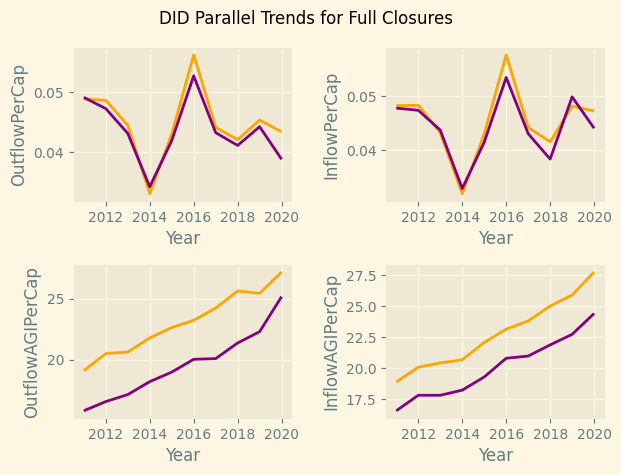

In [20]:
import matplotlib.pyplot as plt

# Get our subgroups
closed_groups['Year'] = closed_groups['Year'].astype(int)
will_close = closed_groups[closed_groups['Converted'] == 0]
will_convert = closed_groups[closed_groups['Converted'] == 1]

fig, axes = plt.subplots(ncols=2, nrows=2)
fig.suptitle('DID Parallel Trends for Full Closures')

vars = ['OutflowPerCap', 'InflowPerCap', 'OutflowAGIPerCap', 'InflowAGIPerCap']

for ax, var in zip(axes.flatten(), vars):
    ax.plot('Year', var, data=unclosed, color='orange')
    ax.plot('Year', var, data=will_close, color='purple')
    ax.set_ylabel(var)
    ax.set_xlabel('Year')

# Kudos to Matplotlib documentation
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.tight_layout.html
plt.tight_layout()


Based on these plots, we seem to fully satisfy the parallel trends assumption throughout our study sample.

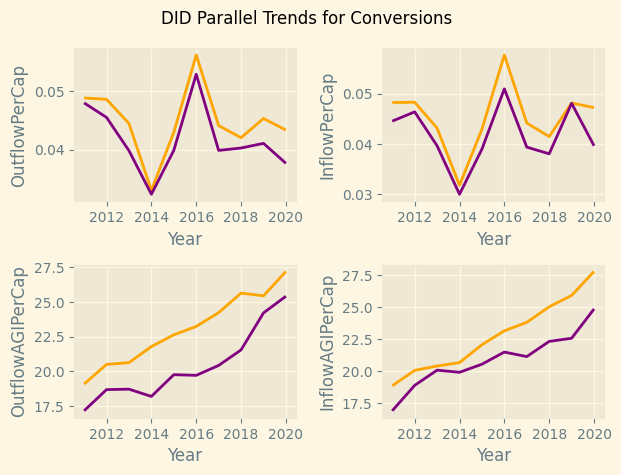

In [21]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=2, nrows=2)
fig.suptitle('DID Parallel Trends for Conversions')

for ax, var in zip(axes.flatten(), vars):
    ax.plot('Year', var, data=unclosed, color='orange')
    ax.plot('Year', var, data=will_convert, color='purple')
    ax.set_ylabel(var)
    ax.set_xlabel('Year')

plt.tight_layout()


Conversions also seem to abide by the parallel trends assumption, although it is much less open and hsut for these. In particular, our AGI per capita variables display some non-parallelisms. 

##### Fully Closed Regressions

We start by regressing over our outflow variables. 

In [22]:
# Construct the variables to regress on or against.
x = diddf.drop(['OutflowPerCap', 'InflowPerCap', 'OutflowAGIPerCap', 'InflowAGIPerCap'], axis=1)
x = sm.add_constant(x)

x_part = x.drop(['prior_full_closure'], axis=1)
x_full = x.drop(['prior_partial_closure'], axis=1)

In [23]:
x_part['prior_partial_closure'].sum()

282

In [24]:
x_full.head()

,const,prior_full_closure,COUNTY_01001,COUNTY_01003,COUNTY_01005,COUNTY_01007,COUNTY_01009,COUNTY_01011,COUNTY_01013,COUNTY_01015,...,Year_2011,Year_2012,Year_2013,Year_2014,Year_2015,Year_2016,Year_2017,Year_2018,Year_2019,Year_2020
0,1.0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
13,1.0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
26,1.0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
39,1.0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
52,1.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [25]:
coeffs_dict = {'full':{}, 'partial':{}}

In [26]:
case_ = 'full'

In [27]:
ols_m = sm.OLS(diddf['OutflowPerCap'], x_full)
results = ols_m.fit()
print(results.summary())

coeffs_dict[case_]['OutflowPerCap'] = (results.params.prior_full_closure, results.pvalues.prior_full_closure)

                            OLS Regression Results                            
Dep. Variable:          OutflowPerCap   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     7.519
Date:                Sat, 02 Mar 2024   Prob (F-statistic):               0.00
Time:                        13:00:34   Log-Likelihood:                 64656.
No. Observations:               24988   AIC:                        -1.244e+05
Df Residuals:                   22555   BIC:                        -1.047e+05
Df Model:                        2432                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               -5.58e+08   1.24

In [28]:
ols_m = sm.OLS(diddf['OutflowAGIPerCap'], x_full)
results = ols_m.fit()
print(results.summary())

coeffs_dict[case_]['OutflowAGIPerCap'] = (results.params.prior_full_closure, results.pvalues.prior_full_closure)

                            OLS Regression Results                            
Dep. Variable:       OutflowAGIPerCap   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     38.79
Date:                Sat, 02 Mar 2024   Prob (F-statistic):               0.00
Time:                        13:01:10   Log-Likelihood:                -71747.
No. Observations:               24988   AIC:                         1.484e+05
Df Residuals:                   22555   BIC:                         1.681e+05
Df Model:                        2432                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -3.907e+11    2.9

In [29]:
ols_m = sm.OLS(diddf['InflowPerCap'], x_full)
results = ols_m.fit()
print(results.summary())

coeffs_dict[case_]['InflowPerCap'] = (results.params.prior_full_closure, results.pvalues.prior_full_closure)

                            OLS Regression Results                            
Dep. Variable:           InflowPerCap   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     51.84
Date:                Sat, 02 Mar 2024   Prob (F-statistic):               0.00
Time:                        13:01:51   Log-Likelihood:                 85886.
No. Observations:               24988   AIC:                        -1.669e+05
Df Residuals:                   22555   BIC:                        -1.471e+05
Df Model:                        2432                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -5.493e+08   5.28

In [30]:
ols_m = sm.OLS(diddf['InflowAGIPerCap'], x_full)
results = ols_m.fit()
print(results.summary())

coeffs_dict[case_]['InflowAGIPerCap'] = (results.params.prior_full_closure, results.pvalues.prior_full_closure)

                            OLS Regression Results                            
Dep. Variable:        InflowAGIPerCap   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     33.01
Date:                Sat, 02 Mar 2024   Prob (F-statistic):               0.00
Time:                        13:02:34   Log-Likelihood:                -79994.
No. Observations:               24988   AIC:                         1.649e+05
Df Residuals:                   22555   BIC:                         1.846e+05
Df Model:                        2432                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -1.309e+11   4.04

In [31]:
case_ = 'partial'

##### Converted Regressions

If we attempt to run this as-is, we'll actually get an error due to SVDs failing to converge. This seems to be due to a lack of converted hospitals as of 2011, so we resolve the error by dropping that year from this section of the analysis.

In [32]:
diddf = diddf.drop(diddf[diddf['Year_2011'] == 1].index).drop('Year_2011', axis=1)
x_part = x_part.drop(x_part[x_part['Year_2011'] == 1].index).drop('Year_2011', axis=1)

In [33]:
ols_m = sm.OLS(diddf['OutflowPerCap'], x_part)
results = ols_m.fit()
print(results.summary())

coeffs_dict[case_]['OutflowPerCap'] = (results.params.prior_partial_closure, results.pvalues.prior_partial_closure)

                            OLS Regression Results                            
Dep. Variable:          OutflowPerCap   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     76.20
Date:                Sat, 02 Mar 2024   Prob (F-statistic):               0.00
Time:                        13:03:13   Log-Likelihood:                 86908.
No. Observations:               22484   AIC:                        -1.690e+05
Df Residuals:                   20052   BIC:                        -1.494e+05
Df Model:                        2431                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -9.351e+

In [34]:
ols_m = sm.OLS(diddf['OutflowAGIPerCap'], x_part)
results = ols_m.fit()
print(results.summary())

coeffs_dict[case_]['OutflowAGIPerCap'] = (results.params.prior_partial_closure, results.pvalues.prior_partial_closure)

                            OLS Regression Results                            
Dep. Variable:       OutflowAGIPerCap   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     40.39
Date:                Sat, 02 Mar 2024   Prob (F-statistic):               0.00
Time:                        13:03:49   Log-Likelihood:                -63187.
No. Observations:               22484   AIC:                         1.312e+05
Df Residuals:                   20052   BIC:                         1.507e+05
Df Model:                        2431                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -7.038e+

In [35]:
ols_m = sm.OLS(diddf['InflowPerCap'], x_part)
results = ols_m.fit()
print(results.summary())

coeffs_dict[case_]['InflowPerCap'] = (results.params.prior_partial_closure, results.pvalues.prior_partial_closure)

                            OLS Regression Results                            
Dep. Variable:           InflowPerCap   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     68.99
Date:                Sat, 02 Mar 2024   Prob (F-statistic):               0.00
Time:                        13:04:26   Log-Likelihood:                 81567.
No. Observations:               22484   AIC:                        -1.583e+05
Df Residuals:                   20052   BIC:                        -1.388e+05
Df Model:                        2431                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -1.972e+

In [36]:
ols_m = sm.OLS(diddf['InflowAGIPerCap'], x_part)
results = ols_m.fit()
print(results.summary())

coeffs_dict[case_]['InflowAGIPerCap'] = (results.params.prior_partial_closure, results.pvalues.prior_partial_closure)

                            OLS Regression Results                            
Dep. Variable:        InflowAGIPerCap   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     31.24
Date:                Sat, 02 Mar 2024   Prob (F-statistic):               0.00
Time:                        13:05:00   Log-Likelihood:                -72056.
No. Observations:               22484   AIC:                         1.490e+05
Df Residuals:                   20052   BIC:                         1.685e+05
Df Model:                        2431                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -3.409e+

And below we have our values in a format that will allow for a (not so happy) table.

In [43]:
coeffs = pd.DataFrame(coeffs_dict)

coeffs['coeffs_full'] = coeffs['full'].apply(lambda x: x[0])
coeffs['p_full'] = coeffs['full'].apply(lambda x: x[1])

coeffs['coeffs_partial'] = coeffs['partial'].apply(lambda x: x[0])
coeffs['p_partial'] = coeffs['partial'].apply(lambda x: x[1])

coeffs.drop(['full', 'partial'], axis=1)


,coeffs_full,p_full,coeffs_partial,p_partial
OutflowPerCap,-0.000431,0.770010,-0.000668,0.494953
OutflowAGIPerCap,-1.230500,0.000375,-0.863247,0.265927
InflowPerCap,0.001468,0.019737,-0.000534,0.666898
InflowAGIPerCap,-1.415829,0.003256,-0.424527,0.712302


Based on the above results, we can say the following.

1. We lack sufficient evidence to say that there is a correlation between a county having a hospital closure -- full or partial -- and changes in outmigration of individuals. Additionally, we lack sufficient evidence to say that there is a correlation between a county having a hospital conversion and changes to individual income in the county and inmigration to the county. 

2. We found three statistically significant effects in teh full closure case: a negative effect on the outflow of aggregate gross income per capita; a negative effect on the _inflow_ of aggregate gross income per capita; and a positive effect on the inflow per capita of individuals to the county.

Our significant results are all _incredibly_ small results. A closure in a county of 20,000, for instance, would only be expected to bring an additional ~29 individuals into the county every year. While every little bit can count, that is an incredibly small effect size.

The effect size on OutflowAGIPerCap and InflowAGIPerCap is also incredibly small relative the size of the variables, with a reasonable way of interpreting these coefficients being that "the average person entering or leaving the county earns about $1.30 less per year than prior to the hospital closure." That is, unsurprisingly, incredibly minimal.

Thus, even with our significant results, these findings support the hypothesis that the partial or full closure of a rural hospital has little or no impact on the migration behavior to it's county. This result is interesting and worrisome: if individuals are not leaving the county in light of hospital closures, then they are instead suffering the consequences of the hospital closure directly, resulting in a greater need for solutions to the rural hospital closure crisis.